# CPSC 425 Homework 2

## Scaled Representations, Face Detection and Image Blending

This project is based off the material that is provided by Matthew Brown's course at 
https://mattabrown.github.io/425/assignments/Assignment2.html




In [66]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import ncc
import os


## Gaussian Pyramid

Here the idea is to build a function that will construct a gaussian pyramid when passed an image

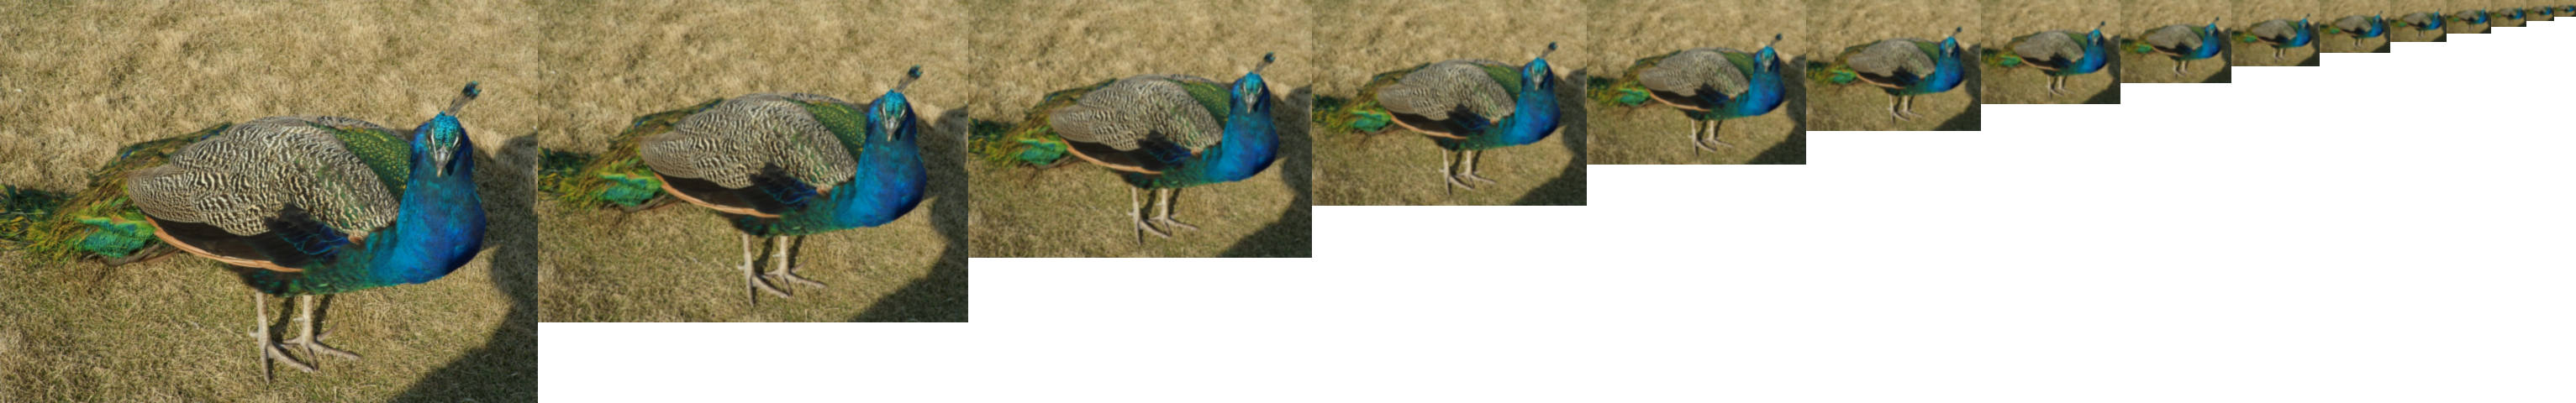

In [67]:
from scipy.ndimage import gaussian_filter as gaussfilter

def array_to_image(a):
    """Converts a numpy array to a PIL Image.
    
    Args:
        a: The numpy array to convert.
        
    Returns:
        A PIL Image.

    """
    
    return Image.fromarray(np.uint8(a))

def downsample(image, scale):
        """Downsamples an image by a scale factor.
        
        Args:
            image: The image to downsample. Can be RGB or grayscale.
            scale: The factor to scale down by.
            
        Returns:
            The downsampled image as a PIL image.
        """
        
        new_width = int(image.size[0]*scale)
        new_height = int(image.size[1]*scale)
        
        return image.resize((new_width, new_height), Image.BICUBIC)

def MakeGaussianPyramid(image, scale, minisize):
    """Creates a Gaussian pyramid of an image.
    Uses a scale factor from one level to the next.
    The pyramid does not fall below minisize in either dimension.
    
    Args:
        image: The image to create the pyramid of. Can be RGB or grayscale.
        scale: The factor to scale down by.
        minisize: The minimum size of the pyramid.
        
    Returns:
        A list of images in the pyramid.
        Includes the original PIL image followed by all the images of reduced size.   

    """
    
    # Check for color image
    isColor = image.mode != "L"
    pyramid = []
    sigma = 1 / (2 * scale)
    image = np.asarray(image)  # Convert PIL Image to numpy array
    pyramid.append(image)  # Append the original image as an array
        
    while image.shape[0] > minisize and image.shape[1] > minisize:
        # Apply a gaussian filter to all channels of the image
        
        if not isColor:
            image = gaussfilter(image, sigma=sigma)
        else:
            for i in range(image.shape[2]):
                image[:, :, i] = gaussfilter(image[:, :, i], sigma=sigma)

        image = downsample(array_to_image(image), scale)  # Convert back to PIL Image for downsampling
        image = np.asarray(image)  # Convert back to numpy array
        pyramid.append(image)
           
    return pyramid


    
def ShowGaussianPyramid(pyramid):
    """ Presents a Gaussian pyramid as a single image.
    Image is to be laid out as one horizontal strip of images.

    Args:
        pyramid: A list of np arrays, ordered from fine to coarse.
    """
    
    # Check if we have a color image
    array = pyramid[0]
    isColor = len(array.shape) == 3 and array.shape[2] == 3
    
    # collect the widths and heights of each image in the pyramid
    heights = [p.shape[0] for p in pyramid]
    widths = [p.shape[1] for p in pyramid]
       
    # Assign an image type based on the input pyramid
    image_type = "RGB" if isColor else "L"
    # Assign a base color to the image background
    base_color = (255,255,255) if isColor else 255    
    
    # Create a new image that is correct width and height
    image = Image.new(image_type, (sum(widths), max(heights)), color=base_color)
    # Insert the sequence of images in order
    for i in range(len(pyramid)):
        image.paste(array_to_image(pyramid[i]), (sum(widths[:i]), 0))
    
    display(image)
    return image

im = Image.open('peacock.png')
# im = Image.open('tree.jpg')

result = MakeGaussianPyramid(im, 0.8, 20)

im = ShowGaussianPyramid(result)   
    

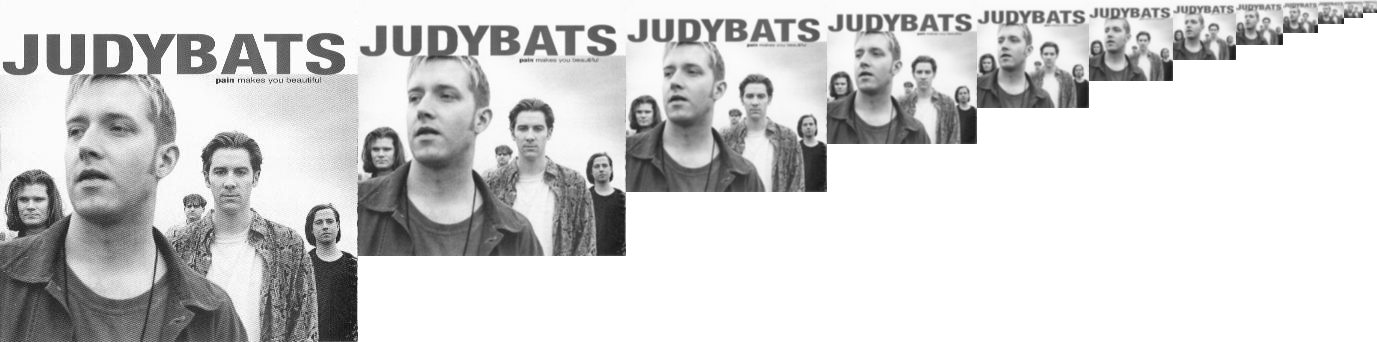

c:\Users\sghys\My Drive (sghyseli@student.ubc.ca)\CPSC425\Assignments\A2\hw2part1\ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


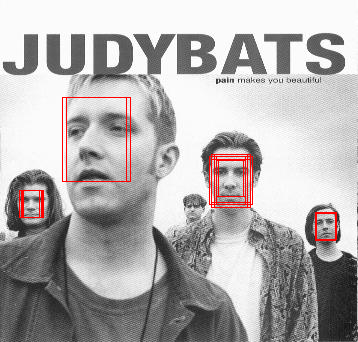

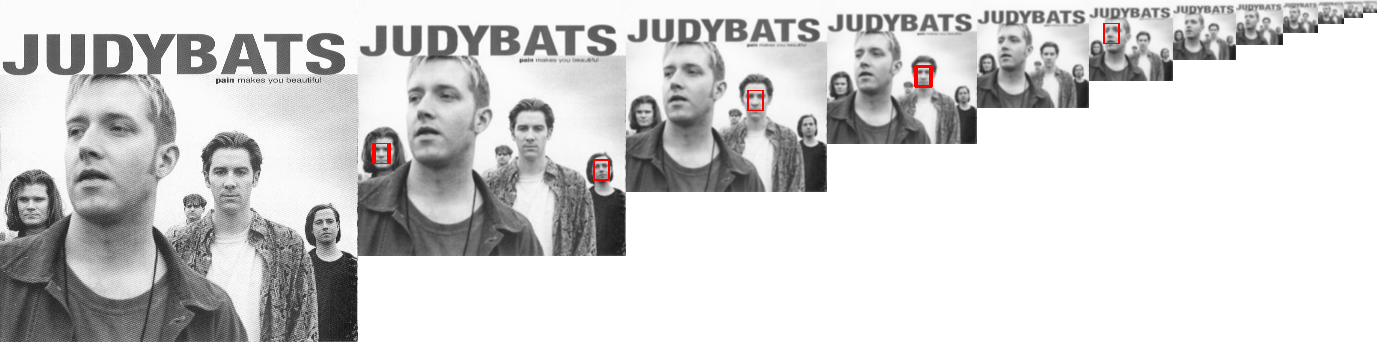

In [68]:
def makeTemplate(img, width):
    """Creates a template from an image with a maximum width. Aspect ratio maintained
    
    Args:
        img: The image to create the template from.
        width: The number of pixels wide the template should be.
        
    Returns:
        A template as a numpy array.
    """
    
    height = int(img.size[1] * width / float(img.size[0]))
    img = img.resize((width, height), Image.BICUBIC)
    
    return img

def display_correlation(cor):
    """Displays a correlation matrix as an image.
    
    Args:
        cor: The correlation matrix to display.
    """
    
    # Normalize the correlation to between 0 and 1
    cor = (cor + 1) / 2
    
    # Convert to a PIL image
    cor = array_to_image(cor*255)
    
    display(cor)


def findFaces(pyramid, template, threshold):
    """Finds matches for a template in an image
    
    Args:
        pyramid: The pyramid to search. A list of greyscale numpy representation images
        template: The template to search for, a PIL image
        threshold: A number between -1 and 1 indicating cutoff for a match in correlation
        
    Returns:
        Base pyramid image with template matches drawn on it.
        A list of (x,y) coordinates of the template in the image.
        
    """
    
    # We find the matches for each sub element of the pyramid and convert the pixel location match 
    # back to the master image    

    # Record dimension of full-scale image
    # Dimensions are in (height,width) for numpy array!
    original_dims = pyramid[0].shape
    
    # Create a list of matches to the template    
    matches = []
    for img in pyramid:
        # Get correlation array
        corr = ncc.normxcorr2D(img,template)
        # Mask for values above threshold
        mask = corr > threshold
        # Find locations of matches
        locations = np.argwhere(mask)
        
        # Calculate scaling factors for each dimension
        y_scale = original_dims[0] / img.shape[0]
        x_scale = original_dims[1] / img.shape[1]
        
        # Scale locations back to original image scale and swap y and x so that tuples are WIDTHxHEIGHT
        scaled_locations = np.round(locations * [y_scale, x_scale]).astype(np.int32)
        # Append to matches list
        matches.append(scaled_locations)
        
    # Draw the matches on the original image
    original_image = array_to_image(pyramid[0])
    
    # Convert the image to RGB if it's not already
    if original_image.mode != 'RGB':
        original_image = original_image.convert('RGB')

    draw = ImageDraw.Draw(original_image)
    for index, set_of_matches in enumerate(matches):
        # Calculate the dimensions of the template box based on the pyramid level
        box_width = np.round(template.width * original_dims[1] / pyramid[index].shape[1]).astype(np.int32)
        box_height = np.round(template.height * original_dims[0] / pyramid[index].shape[0]).astype(np.int32)
        
        for loc in set_of_matches:
            # Draw red rectangles for each match using the appropriate scaled template size
            top_left = (loc[1] - box_width/2 , loc[0] - box_height/2)
            bottom_right = (loc[1] + box_width/2 , loc[0] + box_height/2)
            rectangle = [top_left, bottom_right]

            draw.rectangle(rectangle, outline="red")
            
    return original_image, matches
        
# Open the template image and resize it to a width of 15 pixels
face = Image.open('face_detection_template.jpg')
face = makeTemplate(face, 15)
display(face)


# Open the image to search and convert it to a pyramid
im = Image.open('faces/judybats.jpg')
pyramid = MakeGaussianPyramid(im, 0.75, face.width)
pyramid_im = ShowGaussianPyramid(pyramid)    
        
img, net_matches = findFaces(pyramid, face, 0.65)      
display(img )  

pyramid_array = np.asarray(pyramid_im)

img, mapped_matches = findFaces([pyramid_array], face, 0.65)
display(img)



A good threshold is .60 to .64 for the image recognition. Shown above are the matches in sequential scales and also all in one single scale.

However the model that has been made is inherently biased for white people and so the very clear image of a black baseball player is not registering with the template, even at much lower levels. The images of women in the large group photo are also not registering well, showing gender bias. The images of kids that are tilted over is not registering well, which is explained by the tilted heads and the fact that the face template is positioned upright.

The recall rate is

2/3
0/3
4/5
0/1
20/25
0/0

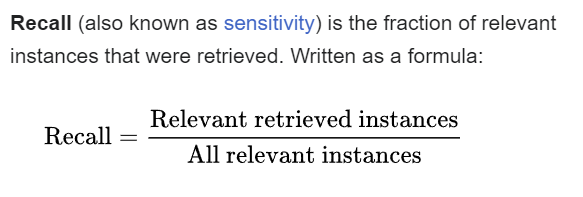

Processing family.jpg


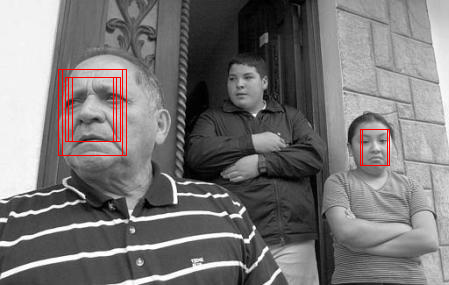

Processing fans.jpg


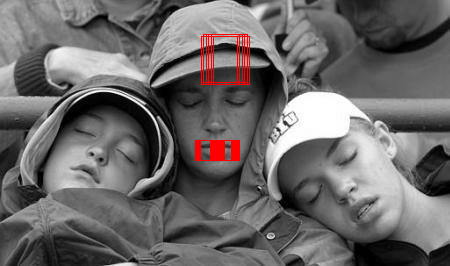

Processing judybats.jpg


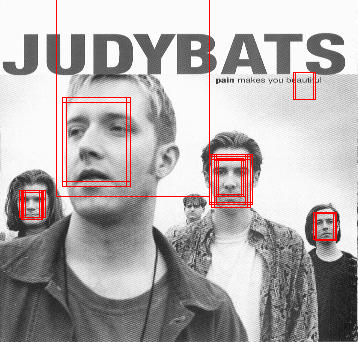

Processing sports.jpg


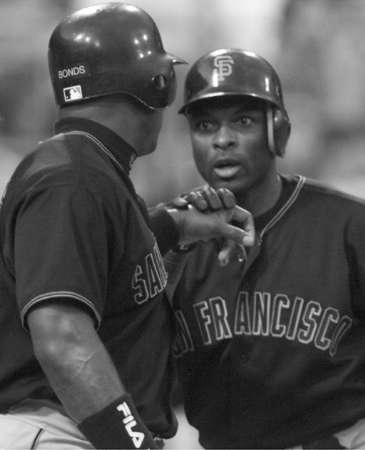

Processing students.jpg


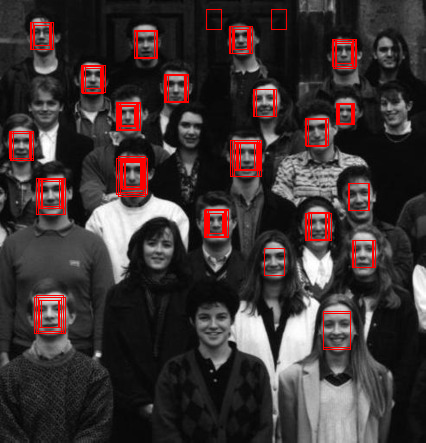

Processing template.jpg


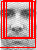

Processing tree.jpg


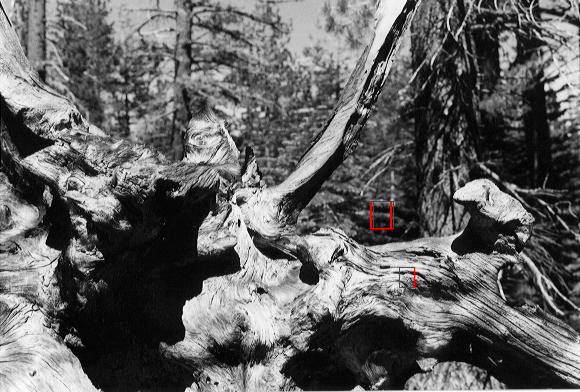

In [84]:
# Directory containing images
image_dir = 'faces/'

# List all files in the directory
files = os.listdir(image_dir)

# Optionally, filter out non-image files based on extension
image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]


# Loop over each image file
for image_file in image_files:
    # Construct full image path
    image_path = os.path.join(image_dir, image_file)

    # Open the image to search and convert it to a pyramid
    im = Image.open(image_path)
    pyramid = MakeGaussianPyramid(im, 0.75, face.width)  # Assuming 'face' is defined

    img, net_matches = findFaces(pyramid, face, 0.61)
    print(f"Processing {image_file}")
    display(img)